In [1]:
# 线性回归从零开始实现，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
# 根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数w=[2,-3.4]^T、b=4.2和噪声项ε生成数据集及其标签
# y = Xw + b + ε
def synthetic_data(w, b, num_examples):
    """生成y = Xw + b + ε噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # X是均值为0，方差为1的随机数，样本数是num-examples，列数是w的长度
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)  # 随机噪音
    return X, y.reshape((-1, 1))  # y作为列向量返回
    
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
# features每一行都包含一个二位数据样本，labels每一行都包含一维标签值（一个标量）
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-1.4521,  0.8138]) 
label: tensor([-1.4685])


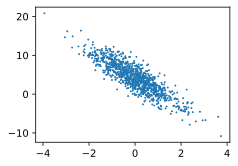

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
               labels.detach().numpy(), 1)

In [5]:
# 定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.7082,  2.1047],
        [ 0.2771, -0.7292],
        [ 0.5053, -1.0061],
        [ 0.2524,  0.4584],
        [ 0.3149, -1.0019],
        [ 0.0063,  0.2450],
        [-0.6878,  1.7061],
        [ 2.2021, -0.7032],
        [-0.7827,  0.1881],
        [-0.1600,  0.1521]]) 
 tensor([[-4.3671],
        [ 7.2320],
        [ 8.6319],
        [ 3.1564],
        [ 8.2359],
        [ 3.3821],
        [-2.9824],
        [10.9986],
        [ 1.9950],
        [ 3.3502]])


In [6]:
# 定义初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

In [7]:
# 定义类型
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [8]:
# 定义损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) **2 / 2

In [9]:
# 定义优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():  # 更新的时候无需梯度计算
        for param in params: # W, b,梯度存在.grad里
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [10]:
# 训练过程
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_1 = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_1.mean()):f}')

epoch 1, loss 0.037068
epoch 2, loss 0.000134
epoch 3, loss 0.000051


In [13]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 0.0002, -0.0011], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0009], grad_fn=<RsubBackward1>)
